<a href="https://colab.research.google.com/github/NobodydeBunny/Cat_Dog_breed_classifire_AI_model/blob/main/Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
(dataset, info) = tfds.load("oxford_iiit_pet",
                            with_info=True,
                            as_supervised=True)

train_ds = dataset['train']
test_ds = dataset['test']
class_names = info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.DXCVOQ_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.DXCVOQ_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [6]:
cat_labels = tf.constant(
    [i for i, name in enumerate(class_names) if name[0].isupper()],
    dtype=tf.int64
)

def is_cat(image, label):
    return tf.reduce_any(tf.equal(cat_labels, label))

train_ds = train_ds.filter(is_cat)
test_ds = test_ds.filter(is_cat)

cat_class_names = [class_names[i] for i in cat_labels.numpy()]
NUM_CLASSES = len(cat_class_names)

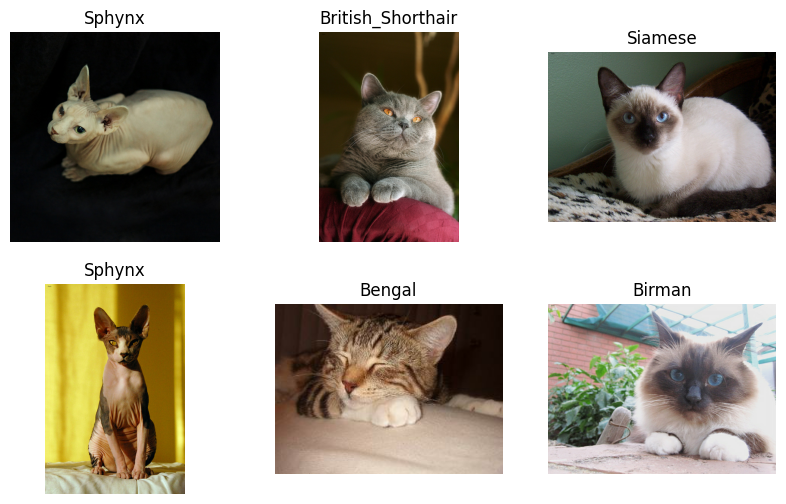

In [7]:
plt.figure(figsize=(10,6))

# Create mapping from original cat label indices
label_map = {original_idx: new_idx for new_idx, original_idx in enumerate(cat_labels.numpy())}

for i, (image, label) in enumerate(train_ds.take(6)):
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.title(cat_class_names[label_map[label.numpy()]])
    plt.axis('off')

plt.show()

In [8]:
IMG_SIZE = 224

# Create lookup table for remapping CAT labels to 0-indexed values
# label_map must already be created from cat_labels
label_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(label_map.keys()), dtype=tf.int64),
        values=tf.constant(list(label_map.values()), dtype=tf.int64)
    ),
    default_value=-1  # Should not be hit if all labels are cat breeds
)

def preprocess(image, label):
    # Cast image to float32
    image = tf.cast(image, tf.float32)

    # Resize image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalize pixel values to range [0,1]
    image = image / 255.0

    # Remap original label indices to sequential 0–11
    remapped_label = label_table.lookup(label)

    return image, remapped_label

# Apply preprocessing
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle dataset
train_ds = train_ds.shuffle(1000)

# Batch dataset
train_ds = train_ds.batch(32)
test_ds  = test_ds.batch(32)

# Prefetch for performance optimization
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
counter = Counter()

for _, label in train_ds.unbatch():
    counter[label.numpy().item()] += 1 # Use .item() to get the scalar value

print("Class Distribution:")
for i in range(NUM_CLASSES):
    print(cat_class_names[i], ":", counter[i])

Class Distribution:
Abyssinian : 100
Bengal : 100
Birman : 100
Bombay : 96
British_Shorthair : 100
Egyptian_Mau : 93
Maine_Coon : 100
Persian : 100
Ragdoll : 100
Russian_Blue : 100
Siamese : 99
Sphynx : 100


In [10]:
# Load pre-trained MobileNetV2 without top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,       # Exclude the default classifier
    weights='imagenet'       # Use ImageNet pre-trained weights
)

# Freeze the convolutional base to retain learned features
base_model.trainable = False

# Build a simple yet effective classification head
model = tf.keras.Sequential([
    base_model,                                      # Pre-trained
    tf.keras.layers.GlobalAveragePooling2D(),       # Pool feature maps into a
    tf.keras.layers.Dense(512, activation='relu'),  # Fully connected layer to
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Stable learning rate for transfer learning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20  # gives top layers enough time to learn
)

Epoch 1/20
     38/Unknown 38s 339ms/step - accuracy: 0.2634 - loss: 2.2620

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 988ms/step - accuracy: 0.2672 - loss: 2.2539 - val_accuracy: 0.6357 - val_loss: 1.4136
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.7605 - loss: 1.1164 - val_accuracy: 0.7566 - val_loss: 0.9356
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.8567 - loss: 0.6772 - val_accuracy: 0.7836 - val_loss: 0.7698
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.9113 - loss: 0.4775 - val_accuracy: 0.7921 - val_loss: 0.6936
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9214 - loss: 0.3644 - val_accuracy: 0.8022 - val_loss: 0.6518
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - accuracy: 0.9485 - loss: 0.2908 - val_accuracy: 0.7946 - val_loss: 0.6249
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 508ms/step - accuracy: 0.9590 - loss: 0.2451 - val_accuracy: 0.8149 - val_loss: 0.5957
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.9675 - loss: 0.1980 - val_accuracy: 0.806

In [13]:
model.save("cat_breed_model.keras")
print("Model saved successfully.")

Model saved successfully.


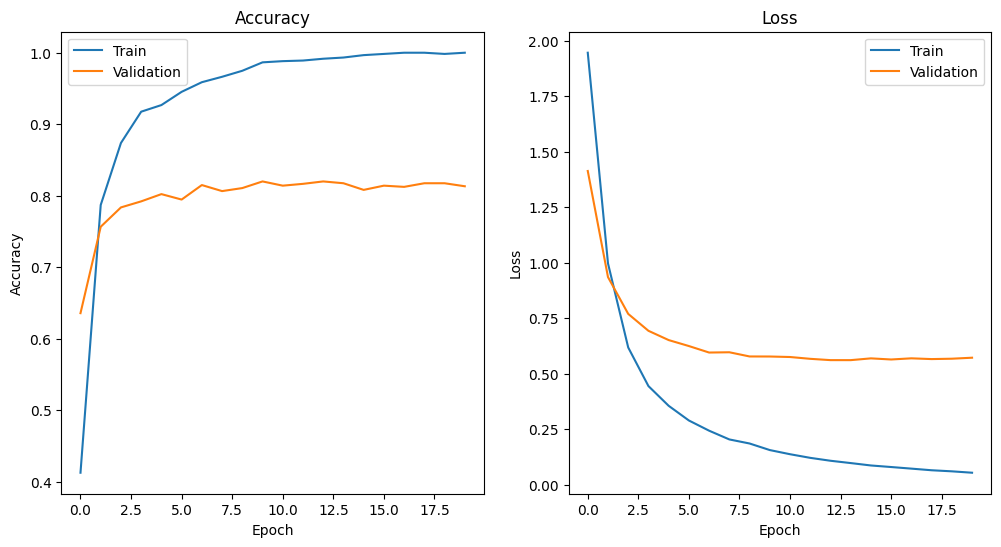

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.8001 - loss: 0.5943
Test Loss: 0.5724
Test Accuracy: 0.8132


In [16]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=cat_class_names))

                   precision    recall  f1-score   support

       Abyssinian       0.81      0.82      0.81        98
           Bengal       0.70      0.85      0.77       100
           Birman       0.73      0.81      0.77       100
           Bombay       0.83      0.91      0.87        88
British_Shorthair       0.80      0.75      0.77       100
     Egyptian_Mau       0.89      0.84      0.86        97
       Maine_Coon       0.82      0.78      0.80       100
          Persian       0.86      0.88      0.87       100
          Ragdoll       0.71      0.66      0.68       100
     Russian_Blue       0.83      0.71      0.76       100
          Siamese       0.90      0.81      0.85       100
           Sphynx       0.92      0.96      0.94       100

         accuracy                           0.81      1183
        macro avg       0.82      0.81      0.81      1183
     weighted avg       0.82      0.81      0.81      1183



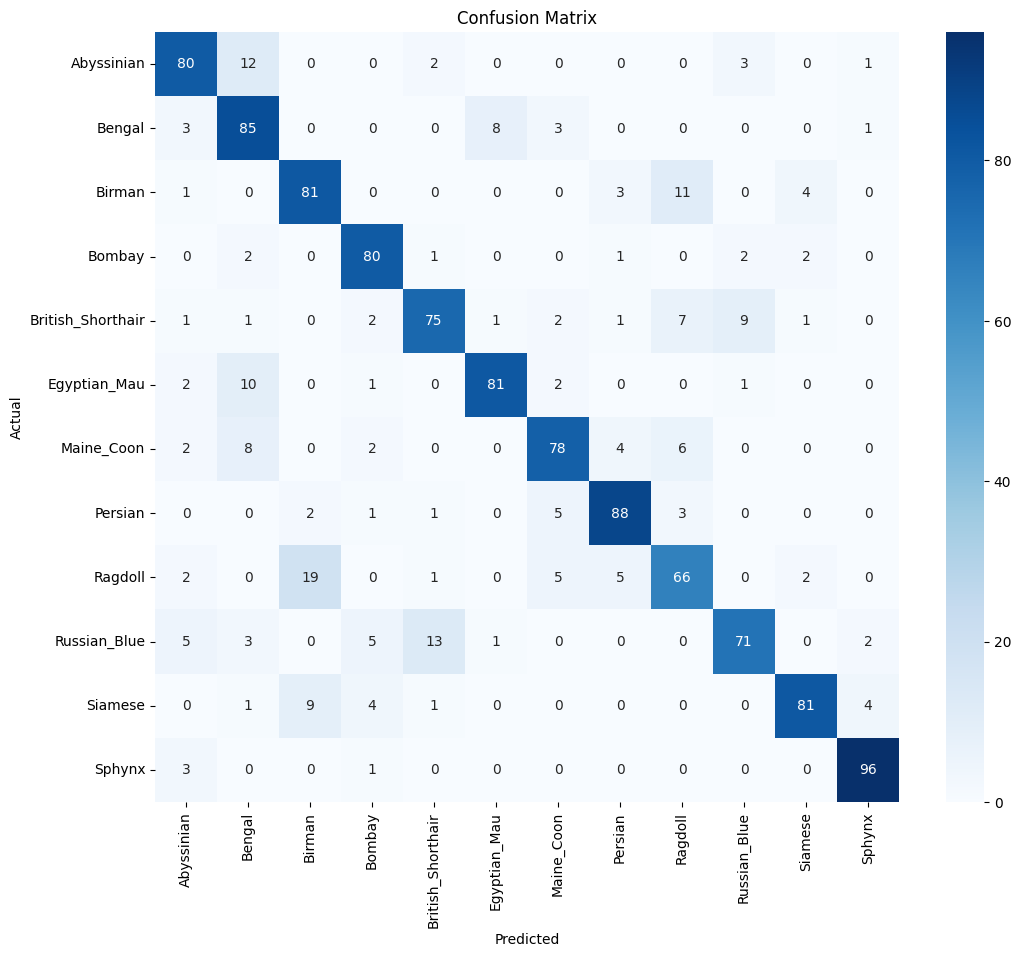

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cat_class_names,
            yticklabels=cat_class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
def predict_and_display(index):
    image, label = list(test_ds.unbatch())[index]
    input_img = tf.expand_dims(image, axis=0)

    probs = model.predict(input_img, verbose=0)[0]
    pred_class = np.argmax(probs)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"True: {cat_class_names[label.numpy()]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.barh(cat_class_names, probs*100)
    plt.xlim(0, 100)
    plt.title(f"Predicted: {cat_class_names[pred_class]}")
    plt.show()

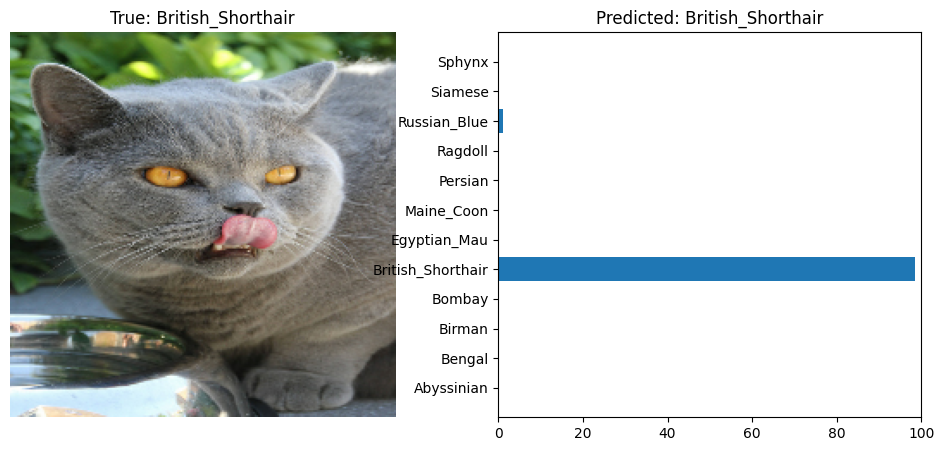

In [23]:
predict_and_display(12)